# REQUIRED MODULES

In [1]:
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['legend.frameon']=False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif']=['Helvetica']
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize']=(12,10)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

from scipy.stats import lognorm
from scipy.constants import pi, g, gas_constant
from scipy.optimize import least_squares
from scipy.optimize import differential_evolution
from scipy.linalg import svd

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# CONVERTS CHORD LENGTH TO DIAMETER

In [2]:
def chord_to_diameter(cbi, rhol, rhog, sigma):
    # Eotvos number
    Eo = (g*(rhol - rhog)*((0.0015*cbi)**2.0))/sigma
    
    # bubble aspect ratio
    E = 1.0/(1.0 + 0.163*(Eo**(0.757)))
    
    # volume equivalent bubble diameter(initial guess)
    dia = 1.5*cbi*(E**(-2.0/3.0))
    
    relError = 1.0
    relTol = 1.0e-8
    
    while(relError > relTol):
        dia_prev = dia
        Eo = (g*(rhol - rhog)*((0.001*dia_prev)**2.0))/sigma
        E = 1.0/(1.0 + 0.163*(Eo**0.757))
        dia = 1.5*cbi*(E**(-2.0/3.0))
        relError = abs((dia - dia_prev)/dia)
    
    return dia

# CREATES BUBBLE CLASSES

In [3]:
def create_classes(df, rhol, rhog, sigma):
    # array for storing bubble count in each class
    count = np.zeros(14)
    
    # array for storing the numerator of locally averaged chord lengths
    cbnums = np.zeros(14)
    
    # array for storing the numerator of locally averaged bubble rise velocities
    ubnums = np.zeros(14)
    
    # number of rows in the input argument, df
    rows = len(df)
    
    for i in range(rows):
        if(df['Chord(mm)'][i] > 0.20 and df['Chord(mm)'][i] < 0.40):
            count[0] = count[0] + 1
            cbnums[0] = cbnums[0] + df['Chord(mm)'][i]
            ubnums[0] = ubnums[0] + df['Velocity(m/s)'][i]
        elif(df['Chord(mm)'][i] > 0.40 and df['Chord(mm)'][i] < 0.60):
            count[1] = count[1] + 1
            cbnums[1] = cbnums[1] + df['Chord(mm)'][i]
            ubnums[1] = ubnums[1] + df['Velocity(m/s)'][i]
        elif(df['Chord(mm)'][i] > 0.60 and df['Chord(mm)'][i] < 0.80):
            count[2] = count[2] + 1
            cbnums[2] = cbnums[2] + df['Chord(mm)'][i]
            ubnums[2] = ubnums[2] + df['Velocity(m/s)'][i]
        elif(df['Chord(mm)'][i] > 0.80 and df['Chord(mm)'][i] < 1.00):
            count[3] = count[3] + 1
            cbnums[3] = cbnums[3] + df['Chord(mm)'][i]
            ubnums[3] = ubnums[3] + df['Velocity(m/s)'][i]
        elif(df['Chord(mm)'][i] > 1.00 and df['Chord(mm)'][i] < 1.20):
            count[4] = count[4] + 1
            cbnums[4] = cbnums[4] + df['Chord(mm)'][i]
            ubnums[4] = ubnums[4] + df['Velocity(m/s)'][i]
        elif(df['Chord(mm)'][i] > 1.20 and df['Chord(mm)'][i] < 1.40):
            count[5] = count[5] + 1
            cbnums[5] = cbnums[5] + df['Chord(mm)'][i]
            ubnums[5] = ubnums[5] + df['Velocity(m/s)'][i]
        elif(df['Chord(mm)'][i] > 1.40 and df['Chord(mm)'][i] < 1.60):
            count[6] = count[6] + 1
            cbnums[6] = cbnums[6] + df['Chord(mm)'][i]
            ubnums[6] = ubnums[6] + df['Velocity(m/s)'][i]
        elif(df['Chord(mm)'][i] > 1.60 and df['Chord(mm)'][i] < 1.80):
            count[7] = count[7] + 1
            cbnums[7] = cbnums[7] + df['Chord(mm)'][i]
            ubnums[7] = ubnums[7] + df['Velocity(m/s)'][i]
        elif(df['Chord(mm)'][i] > 1.80 and df['Chord(mm)'][i] < 2.00):
            count[8] = count[8] + 1
            cbnums[8] = cbnums[8] + df['Chord(mm)'][i]
            ubnums[8] = ubnums[8] + df['Velocity(m/s)'][i]
        elif(df['Chord(mm)'][i] > 2.00 and df['Chord(mm)'][i] < 2.20):
            count[9] = count[9] + 1
            cbnums[9] = cbnums[9] + df['Chord(mm)'][i]
            ubnums[9] = ubnums[9] + df['Velocity(m/s)'][i]
        elif(df['Chord(mm)'][i] > 2.20 and df['Chord(mm)'][i] < 2.40):
            count[10] = count[10] + 1
            cbnums[10] = cbnums[10] + df['Chord(mm)'][i]
            ubnums[10] = ubnums[10] + df['Velocity(m/s)'][i]
        elif(df['Chord(mm)'][i] > 2.40 and df['Chord(mm)'][i] < 2.60):
            count[11] = count[11] + 1
            cbnums[11] = cbnums[11] + df['Chord(mm)'][i]
            ubnums[11] = ubnums[11] + df['Velocity(m/s)'][i]
        elif(df['Chord(mm)'][i] > 2.60 and df['Chord(mm)'][i] < 2.80):
            count[12] = count[12] + 1
            cbnums[12] = cbnums[12] + df['Chord(mm)'][i]
            ubnums[12] = ubnums[12] + df['Velocity(m/s)'][i]
        elif(df['Chord(mm)'][i] > 2.80 and df['Chord(mm)'][i] < 3.00):
            count[13] = count[13] + 1
            cbnums[13] = cbnums[13] + df['Chord(mm)'][i]
            ubnums[13] = ubnums[13] + df['Velocity(m/s)'][i]
    
    classes = np.zeros([14,3])
    for j in range(14):
        Cbri = cbnums[j]/count[j]
        dbri = chord_to_diameter(Cbri, rhol, rhog, sigma)
        classes[j,0] = dbri
        classes[j,1] = ubnums[j]/count[j]
        classes[j,2] = count[j]
    
    return classes

# RADIALLY AVERAGES LOCAL BUBBLE PROPERTIES

In [4]:
def radially_average(class_dict, P, eg_real, eg_folder, UL, rhol, rhog, sigma):
    R = 0.50*0.1016
    rR = ['-0.80', '-0.60', '-0.40', '-0.20', '0', '0.20', '0.40', '0.60', '0.80']
    
    A0 = 0.50*pi*(R**2 - (-0.80*R)**2)
    A1 = 0.50*pi*((-0.80*R)**2 - (-0.60*R)**2)
    A2 = 0.50*pi*((-0.60*R)**2 - (-0.40*R)**2)
    A3 = 0.50*pi*((-0.40*R)**2 - (-0.20*R)**2)
    A4 = 0.50*pi*((-0.20*R)**2 - (0.00*R)**2)
    A5 = 0.50*pi*((0.20*R)**2 - (0.0*R)**2)
    A6 = 0.50*pi*((0.40*R)**2 - (0.20*R)**2)
    A7 = 0.50*pi*((0.60*R)**2 - (0.40*R)**2)
    A8 = 0.50*pi*((0.80*R)**2 - (0.60*R)**2)
    
    A = [A0, A1, A2, A3, A4, A5, A6, A7, A8]
    
    dbnums = np.zeros(14)
    dbdens = np.zeros(14)
    Ubnums = np.zeros(14)
    Ubdens = np.zeros(14)
    
    for i in range(9):
        key = 'P' + str(P) + '-eG' + str(eg_folder) + '-rR' + rR[i]
        arr = class_dict[key]
        for j in range(14):
            dbnums[j] = dbnums[j] + (arr[j,0]**3.0)*arr[j,2]*A[i]
            dbdens[j] = dbdens[j] + arr[j,2]*A[i]
            Ubnums[j] = Ubnums[j] + arr[j,1]*(arr[j,0]**3.0)*arr[j,2]*A[i]
            Ubdens[j] = Ubdens[j] + (arr[j,0]**3.0)*arr[j,2]*A[i]
            
    results = np.zeros([14,3])
    for k in range(14):
        dbi = (dbnums[k]/dbdens[k])**(1.0/3.0)
        results[k,0] = dbi
        
        Ubi = Ubnums[k]/Ubdens[k]
        Usi = Ubi - UL/(1.0 - eg_real)
        results[k,1] = Usi
        
        Eo = (g*(rhol - rhog)*(0.001*dbi)**2.0)/sigma
        E = 1.0/(1.0 + 0.163*(Eo**0.757)) 
        Cdi = (4.0/3.0)*(rhol-rhog)/rhol*(g*(0.001*dbi)*E**(2.0/3.0))/(Usi**2.0)
        results[k,2] = Cdi

    return results

# MODEL FUNCTION

In [5]:
def model(beta0, beta1, beta2, Re, Eo, eg, p_norm):
    Cdi_pred = (24.0/Re)*(1.0 + (Re*Eo)**beta0)*(1.0-eg)**(beta1*(1.0-np.exp(-beta2*p_norm)))
    return Cdi_pred

# OBJECTIVE FUNCTIONS

In [6]:
def objfunc(betas, *xydata):
    beta0, beta1, beta2 = betas[0], betas[1], betas[2]
    Re, Eo, eg, p_norm, y = xydata
    yhat = model(beta0, beta1, beta2, Re, Eo, eg, p_norm)
    residual = (y-yhat)
    return residual

In [7]:
def objfunc_differential(betas, *xydata):
    beta0, beta1, beta2 = betas[0], betas[1], betas[2]
    Re, Eo, eg, p_norm, ydata = xydata
    yhat = model(beta0, beta1, beta2, Re, Eo, eg, p_norm)
    ss_residuals = 0.0
    for i in range(len(yhat)):
        ss_residuals = ss_residuals + (yhat[i]-ydata[i])**2
    return ss_residuals

# DRAG COEFFICIENTS

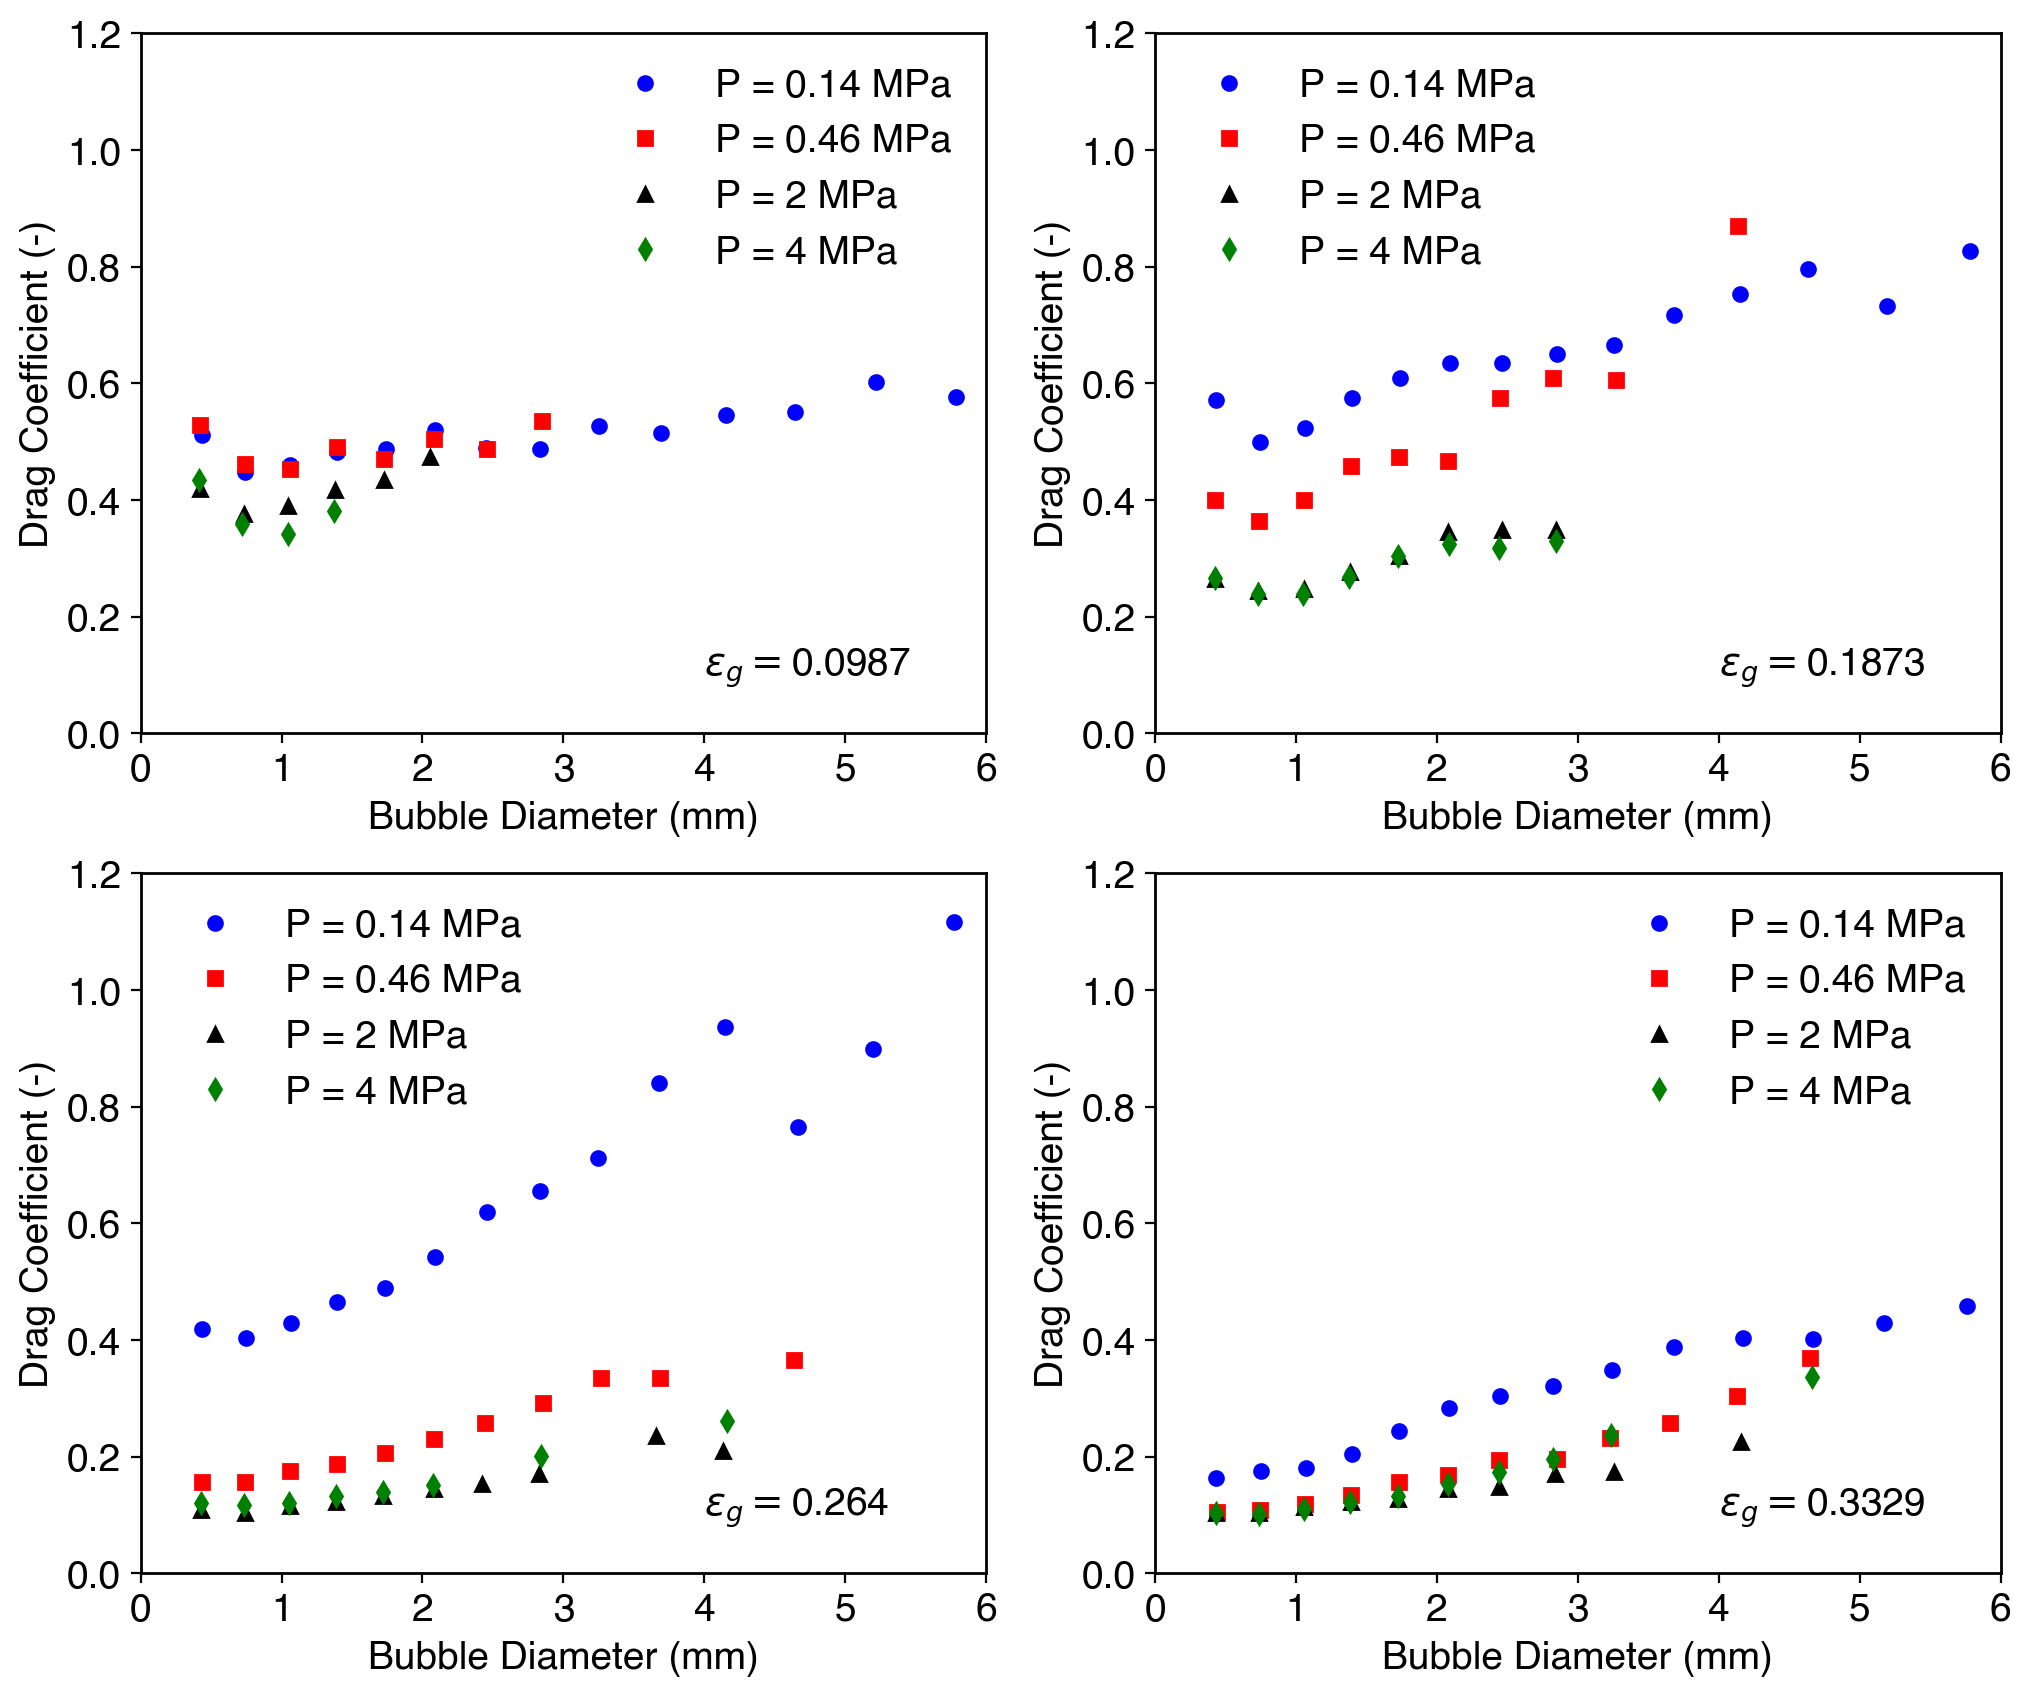

CPU times: user 28.7 s, sys: 252 ms, total: 28.9 s
Wall time: 29.9 s


In [8]:
%%time
# current working directory
main_dir = os.getcwd()

# actual gas holdups
eg_real = [0.092, 0.102, 0.098, 0.104, 
           0.178, 0.190, 0.187, 0.194,
           0.271, 0.242, 0.264, 0.279, 
           0.335, 0.324, 0.331, 0.342]

# For locating gas holdup folders (mean values)
eg_folder = [0.0987, 0.1873, 0.264, 0.3329]

# actual operating pressures (MPa)
# first row for the lowest mean gas holdup
# last row for the highest mean gas holdup
p_real = [0.14, 0.43, 2.0, 4.2,
          0.14, 0.46, 2.0, 4.0, 
          0.14, 0.46, 2.1, 3.9,
          0.14, 0.48, 2.1, 3.8]

# For locating pressure folders (mean values)
p_folder = [0.14, 0.46, 2, 4]

# actual operating temperatures (K)
# first row for the lowest mean gas holdup
# last row for the highest mean gas holdup
Temp = [300.45, 300.235, 301.290, 303.340, 
        300.96, 300.29, 302.20, 303.853, 
        301.50, 300.66, 302.93, 304.137, 
        301.63, 299.543, 303.340, 304.608]

# liquid density
rhol = 998.0

# surface tension
sigma = 0.068

# liquid superficial velocity (m/s)
UL = 0.030

# dictionary for storing bubble classes at each radial position
bins = {}

# pandas data frame for storing radially averaged data for external plotting
drag_data = pd.DataFrame(data=None)

# list and dictionary for storing modelling data
m_data = []
mdict = {}

# Initiate plotting
markers = ['bo', 'rs', 'k^', 'gd']
for i in range(len(eg_folder)):
    plt.subplot(2,2,i+1)
    for j in range(len(p_folder)):
        # actual gas holdup
        eg = eg_real[4*i + j]
        
        # actual temperature
        T = Temp[4*i + j]
        
        # actual pressure
        p = p_real[4*i + j]
        
        # gas density
        rhog = (p*1e6*0.028)/(gas_constant*T)
        
        # path to files
        path_to_files = main_dir + '/P = ' + str(p_folder[j]) + ' MPa/eG = ' + str(eg_folder[i])
        
        # obtain names of files in the directory specified above
        file_names = glob.glob(os.path.join(path_to_files, '*.txt'))
        for fname in file_names:
            # remove path from file name
            _, f = os.path.split(fname)
            
            # remove file extension from file name obtained above
            key, _ = os.path.splitext(f)
            
            # read file contents into a data frame
            df = pd.read_csv(fname, delimiter='\t')
            
            # bin bubbles into pre-determined classes & add the result to a dictionary
            bins[key] = create_classes(df, rhol, rhog, sigma)
            
        # radially average local bubble properties
        # also compute individual drag coefficients
        global_averages = radially_average(bins, p_folder[j], eg, eg_folder[i], UL, rhol, rhog, sigma)
        
        # plot global data
        plt.plot(global_averages[:,0], global_averages[:,2], markers[j], ms=5, label = 'P = ' + str(p_folder[j]) + ' MPa')
        
        # store radially averaged data for external plotting
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-dbi'] = global_averages[:,0]
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-Usi'] = global_averages[:,1]
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-Cdi'] = global_averages[:,2]
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-pPrime']=(p/0.10)*np.ones(14)
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-eg'] = eg*np.ones(14)
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-Re'] = (rhol*global_averages[:,1]*0.001*global_averages[:,0])/0.000935
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-Eo'] = ((rhol - rhog)*g*((0.001*global_averages[:,0])**2.0))/sigma
    
        # modelling data  
        Re = (rhol*global_averages[:,1]*0.001*global_averages[:,0])/0.000935
        Eo = ((rhol - rhog)*g*((0.001*global_averages[:,0])**2.0))/sigma
        We = (rhol*((global_averages[:,1])**2.0)*0.001*global_averages[:,0])/sigma
        pNorm = p/(0.1*We)
        mdict['Re'] = Re
        mdict['Eo'] = Eo
        mdict['eg'] = eg*np.ones(14)
        mdict['p_norm'] = pNorm
        mdict['Cdi'] = global_averages[:,2]
        mdf = pd.DataFrame(mdict)
        m_data.append(mdf)
        
    # plotting 
    plt.xlabel('Bubble Diameter (mm)')
    plt.ylabel('Drag Coefficient (-)')
    plt.xlim([0,6])
    plt.ylim([0,1.2])
    plt.text(4,0.1,r'$\varepsilon_g = $'+str(eg_folder[i]))
    plt.legend()
plt.show()

# export all data to text files
model_data = pd.concat(m_data, ignore_index=True)
#model_data.to_csv('pnorm2-model_data.txt', sep='\t', index=False, na_rep='nan')
#drag_data.to_csv('pnorm2-drag_data.txt', sep='\t', index=False, na_rep='nan')

# CHORD LENGTH DISTRIBUTIONS

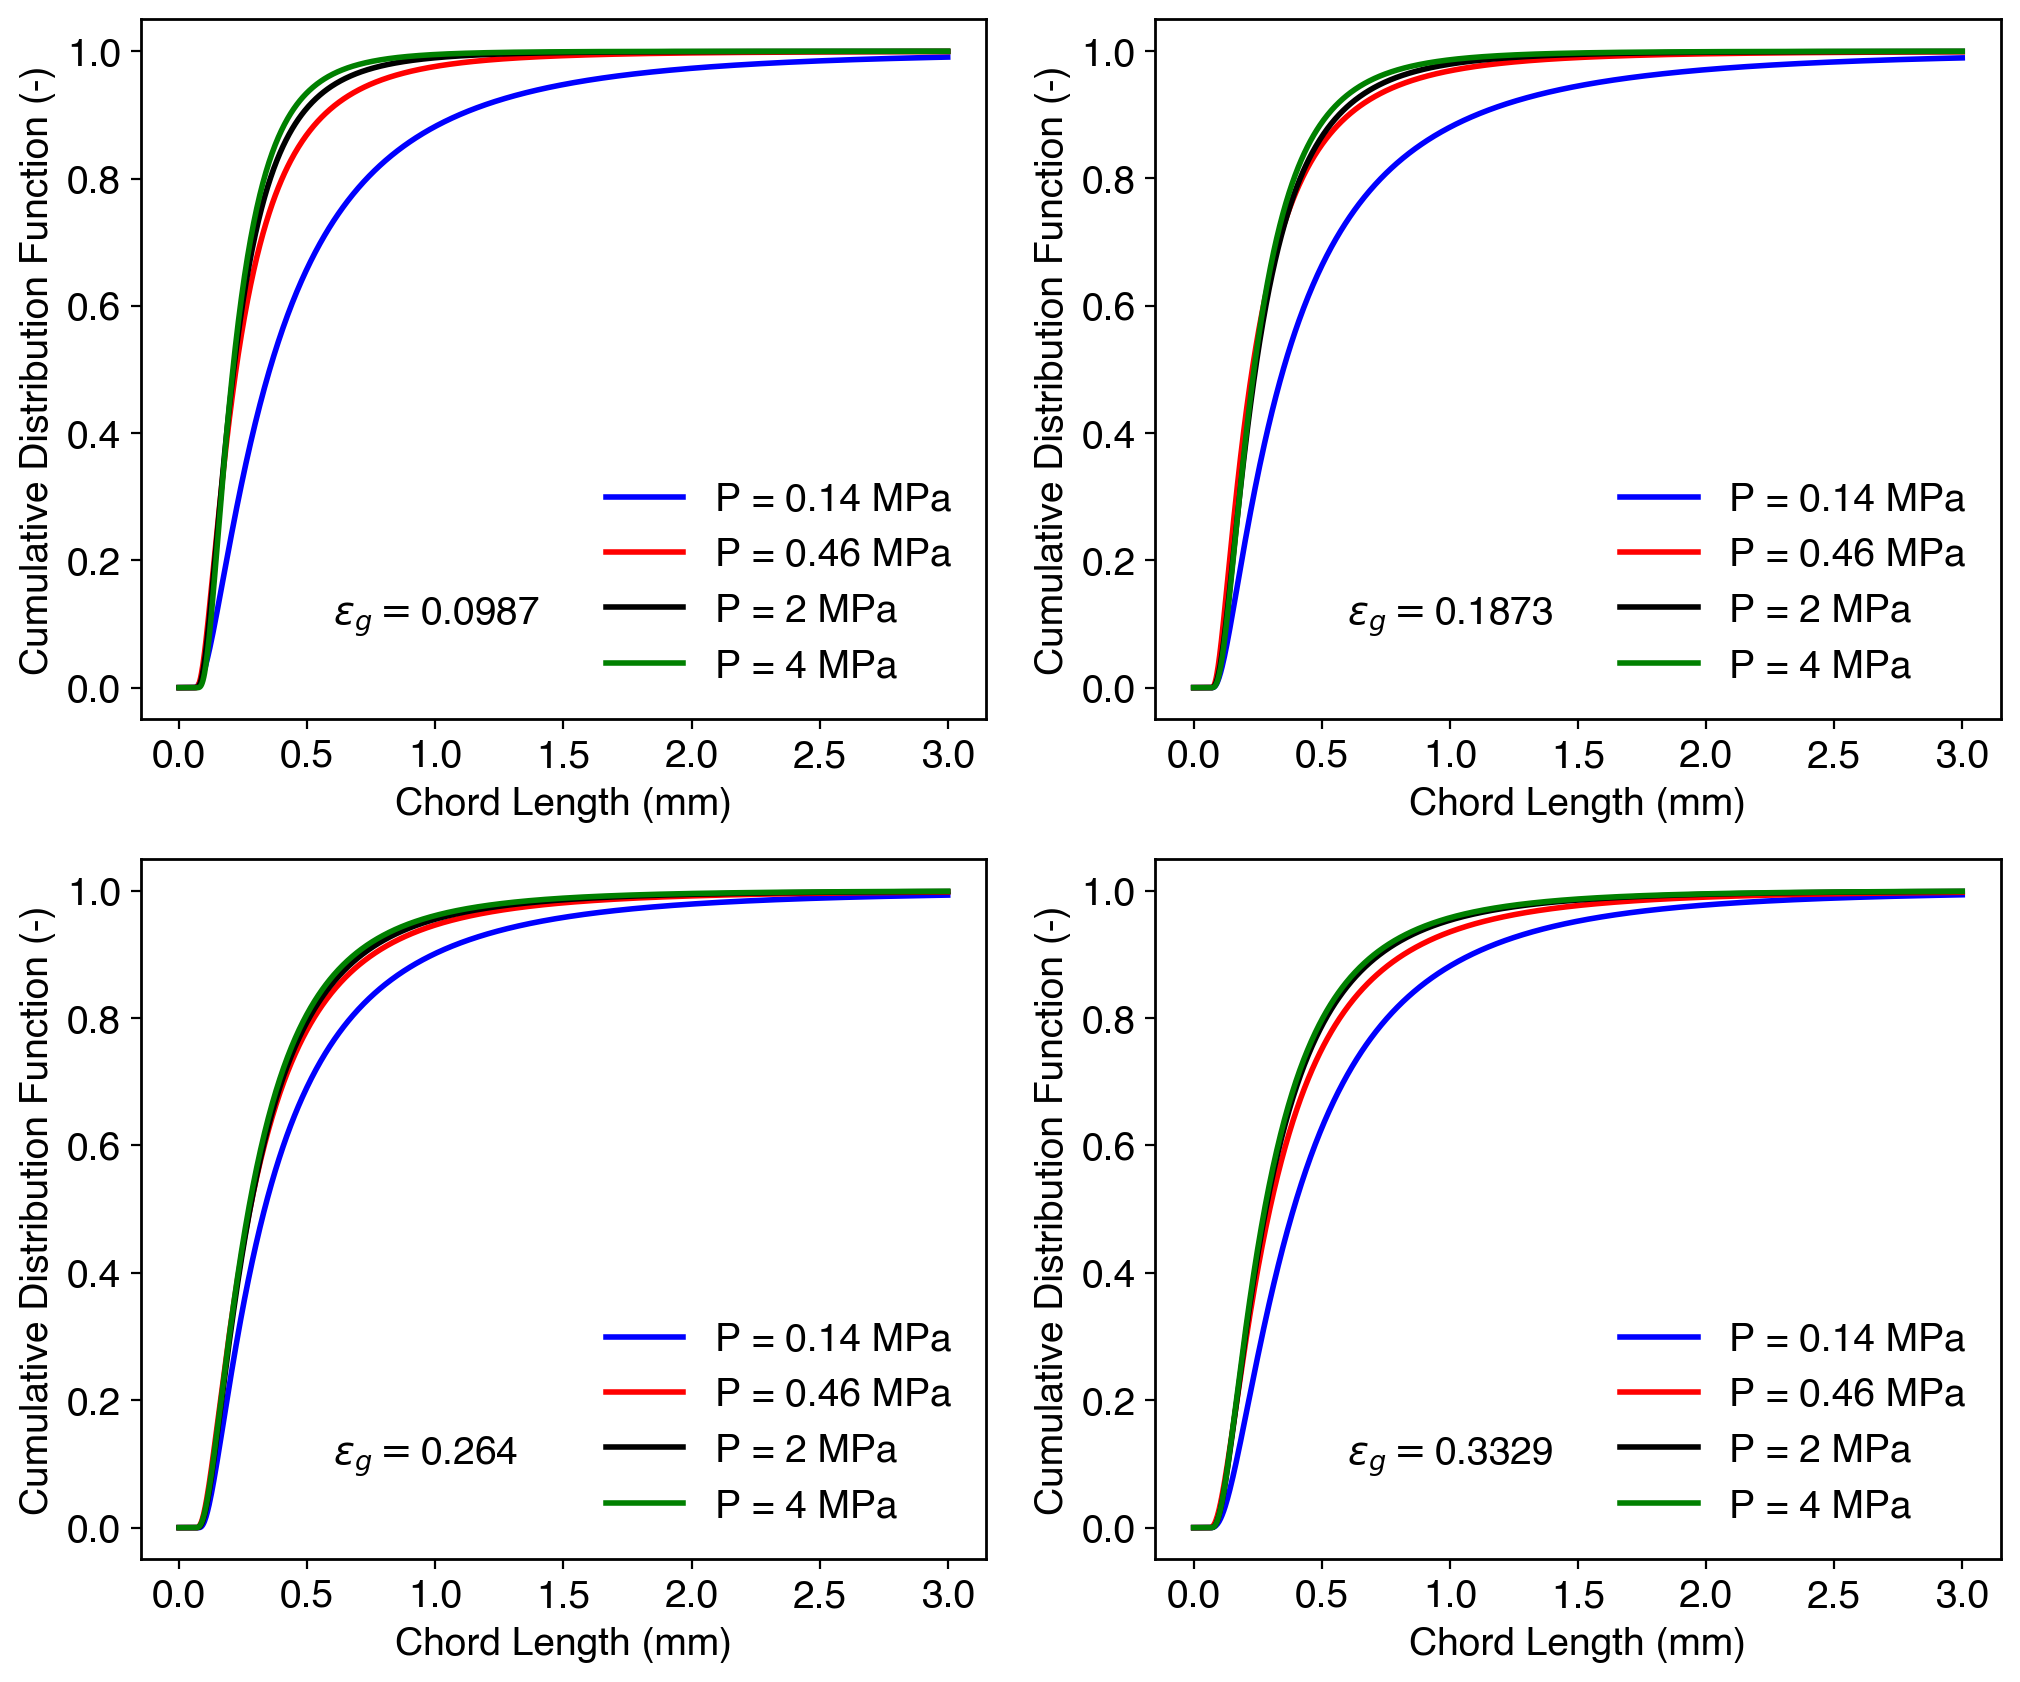

CPU times: user 2.42 s, sys: 247 ms, total: 2.67 s
Wall time: 3.45 s


In [9]:
%%time
# chord lengths for plotting cumulative distribution function
chords = np.linspace(0, 3, 1000)

# data frame for storing cumulative distribution functions
df_plot = pd.DataFrame(chords, columns=['Chord'])

# plotting
plt.figure(figsize= [12, 10])
lstyles = ['solid', 'solid', 'solid', 'solid']
lcolors = ['blue', 'red', 'black', 'green']

# loop counters
i = 0
for eg in eg_folder:
    plt.subplot(2,2, i+1)
    j=0
    for p in p_folder:
        path_to_files = main_dir + '/P = ' + str(p) + ' MPa' + '/eG = ' + str(eg)
        files = sorted(glob.glob(os.path.join(path_to_files,'*.txt')))
        list_df = []
        for file in files:
            list_df.append(pd.read_csv(file, delimiter='\t'))
        df = pd.concat(list_df)
        shape, loc, scale = lognorm.fit(df['Chord(mm)'])
        cdf = lognorm.cdf(chords, shape, loc, scale)
        pdf = lognorm.pdf(chords, shape, loc, scale)
        df_plot['cdf-P'+str(int(1000*p))+'-eG' + str(int(10000*eg))] = cdf
        df_plot['pdf-P'+str(int(1000*p))+'-eG' + str(int(10000*eg))] = pdf
        plt.plot(chords,cdf,linestyle=lstyles[j], color=lcolors[j], linewidth=2, alpha=1, label='P = ' + str(p_folder[j]) + ' MPa')
        j = j + 1
    plt.xlabel('Chord Length (mm)')
    plt.ylabel('Cumulative Distribution Function (-)')
    plt.text(0.6,0.1,r'$\varepsilon_g = $'+str(eg_folder[i]))
    plt.legend()
    i = i + 1
plt.show()
#df_plot.to_csv('pnorm2-chord-length-cdf.txt', sep = '\t', index=False)

# INITIAL PARAMETER ESTIMATES WITH DIFFERENTIAL EVOLUTION

differential_evolution step 1: f(x)= 22.0819
differential_evolution step 2: f(x)= 21.8119
differential_evolution step 3: f(x)= 21.5042
differential_evolution step 4: f(x)= 20.2137
differential_evolution step 5: f(x)= 5.80993
differential_evolution step 6: f(x)= 5.80993
differential_evolution step 7: f(x)= 5.30171
differential_evolution step 8: f(x)= 5.30171
differential_evolution step 9: f(x)= 3.96923
differential_evolution step 10: f(x)= 3.96923
differential_evolution step 11: f(x)= 3.60277
differential_evolution step 12: f(x)= 3.60277
differential_evolution step 13: f(x)= 2.20088
differential_evolution step 14: f(x)= 2.20088
differential_evolution step 15: f(x)= 2.20088
differential_evolution step 16: f(x)= 2.20088
differential_evolution step 17: f(x)= 2.20088
differential_evolution step 18: f(x)= 2.20088
differential_evolution step 19: f(x)= 2.20088
differential_evolution step 20: f(x)= 2.20088
differential_evolution step 21: f(x)= 2.20088
differential_evolution step 22: f(x)= 2.200

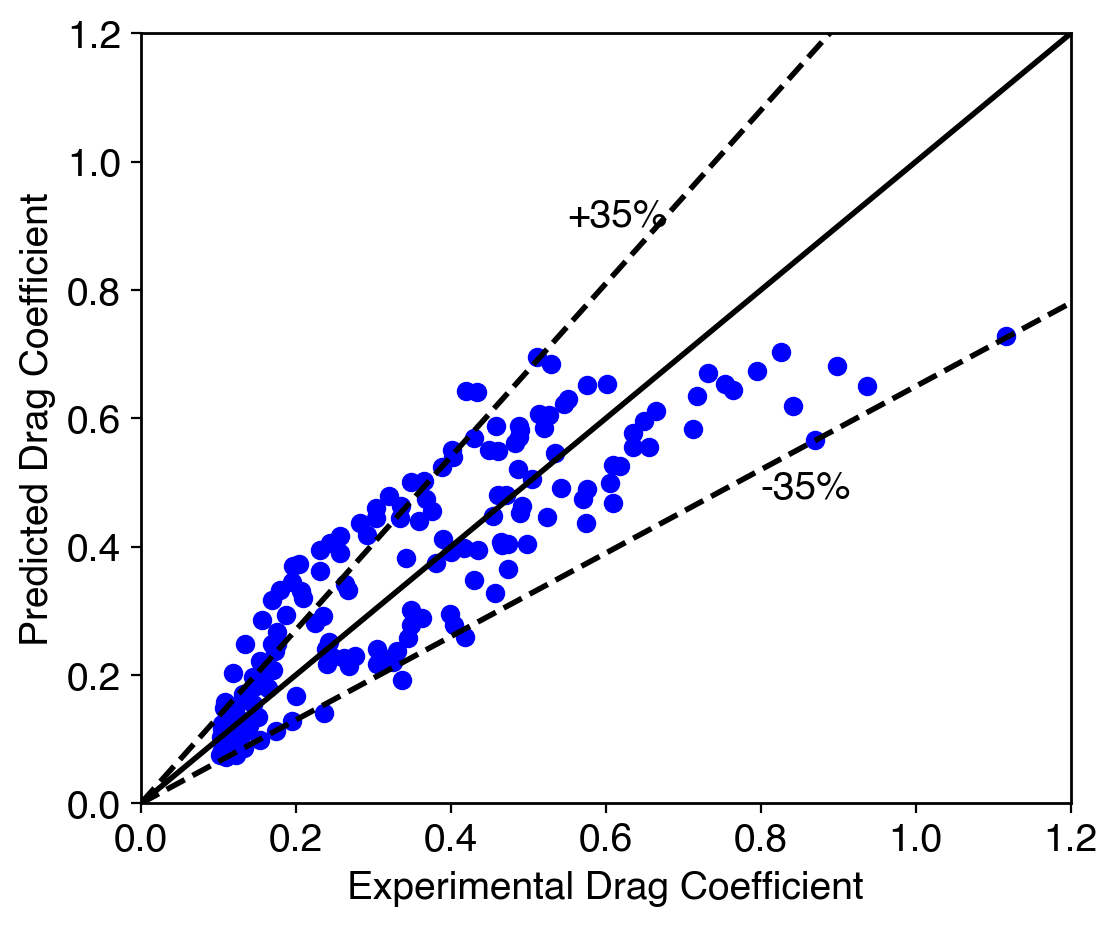

CPU times: user 4.5 s, sys: 166 ms, total: 4.66 s
Wall time: 5.96 s


In [10]:
%%time
# drop rows with missing values
model_data.dropna(inplace=True)
model_data.reset_index(drop=True, inplace=True)

# independent variables
Re = model_data['Re']
Eo = model_data['Eo']
eg = model_data['eg']
p_norm = model_data['p_norm']

# dependent variable
Cdi = model_data['Cdi']

# xydata
xydata = (Re, Eo, eg, p_norm, Cdi)

# initial model parameters
betas_ = np.array([0.46, 3.96, -0.09])

# bounds
bounds = [(-10,10), (-10,10), (-10,10)]

params_de = differential_evolution(objfunc_differential, bounds, args=(xydata), strategy='best1exp', x0=betas_, init='halton', workers=1, disp=True)
print(params_de)

Cdi_pred = model(params_de.x[0], params_de.x[1], params_de.x[2], Re, Eo, eg, p_norm)

plt.rcParams['figure.figsize']=(6,5)

plt.plot(Cdi, Cdi_pred, 'bo')
plt.plot([0,1.2],[0,1.2],'k-')
plt.plot([0,1.2],[0,1.62],'k--')
plt.plot([0,1.846],[0,1.2],'k--')
plt.xlim([0,1.2])
plt.ylim([0,1.2])
plt.xlabel('Experimental Drag Coefficient')
plt.ylabel('Predicted Drag Coefficient')
plt.text(0.8,0.475,'-35%')
plt.text(0.55,0.9,'+35%')
plt.show()

# FINAL PARAMETER ESTIMATES WITH NON-LINEAR LEAST SQUARES

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.7969e-01                                    2.42e-01    
       1              2         8.7966e-01      3.42e-05       7.76e-03       1.07e-03    
       2              3         8.7966e-01      4.07e-08       4.09e-04       2.83e-04    
       3              4         8.7966e-01      5.92e-09       3.04e-05       9.88e-05    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 8.7969e-01, final cost 8.7966e-01, first-order optimality 9.88e-05.
beta1 = 0.43 +/- 0.00, beta2 = 4.29 +/- 0.23, beta3 = 0.22 +/- 0.03
R^2 = 0.74


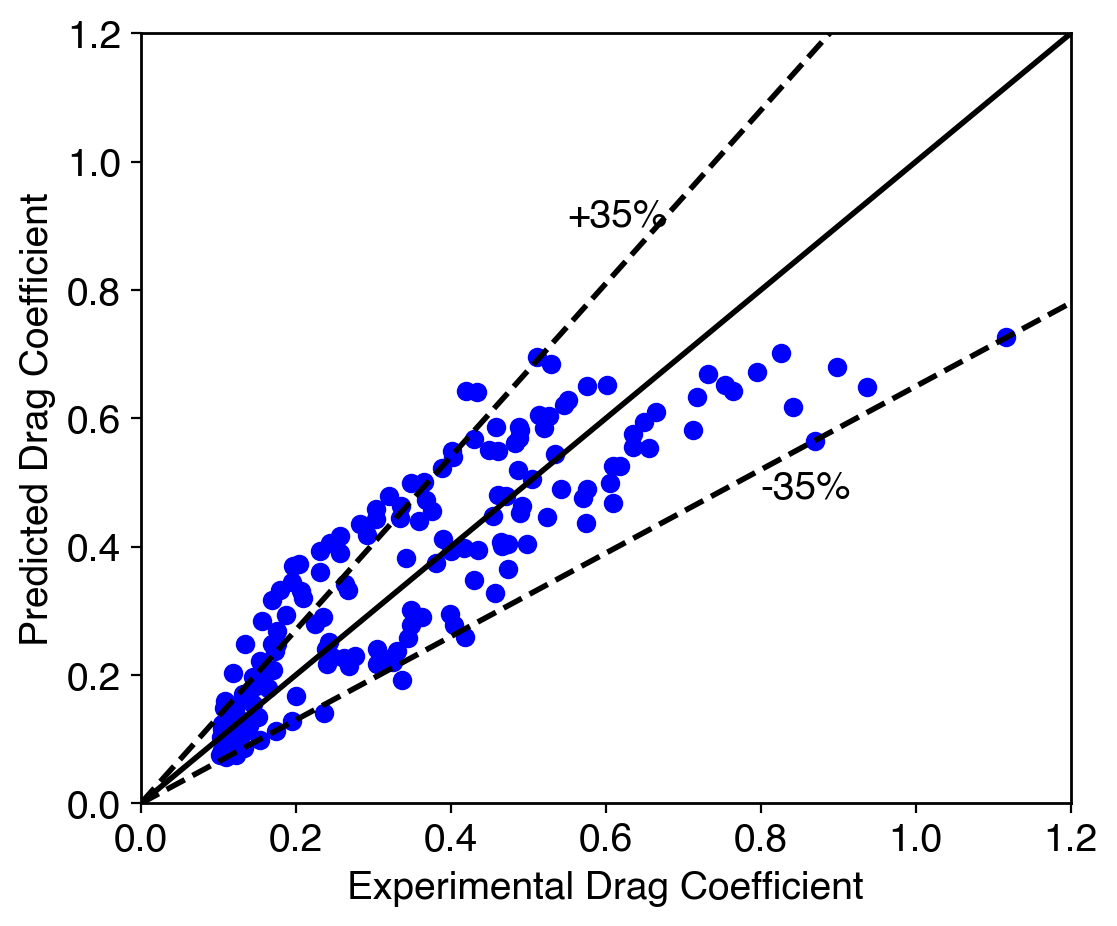

CPU times: user 411 ms, sys: 68.8 ms, total: 480 ms
Wall time: 332 ms


In [11]:
%%time
# parameter estimation
params = least_squares(objfunc, params_de.x, args=(xydata), method='trf', loss='soft_l1', tr_solver='lsmr', verbose=2)

# model predictions
Cdi_pred = model(params.x[0], params.x[1], params.x[2], Re, Eo, eg, p_norm)

# estimate R^2
squared_res = (Cdi-Cdi_pred)**2
ssr = np.sum(squared_res)
sst = np.sum((Cdi - np.mean(Cdi))**2)
Rsq = 1.0 - (ssr/sst)

# estimate errors on fitted parameters
U, s, Vh = svd(params.jac, full_matrices=True)
tol = np.finfo(float).eps*s[0]*max(params.jac.shape)
w = s > tol
cov = (Vh[w].T/s[w]**2) @ Vh[w]  
perr = np.sqrt(np.diag(cov))/np.sqrt(len(Cdi)-1)  

print(f'beta1 = {params.x[0]:.2f} +/- {perr[0]:.2f}, beta2 = {params.x[1]:.2f} +/- {perr[1]:.2f}, beta3 = {params.x[2]:.2f} +/- {perr[2]:.2f}')
print(f'R^2 = {Rsq:.2f}')

plt.plot(Cdi, Cdi_pred, 'bo')
plt.plot([0,1.2],[0,1.2],'k-')
plt.plot([0,1.2],[0,1.62],'k--')
plt.plot([0,1.846],[0,1.2],'k--')
plt.xlim([0,1.2])
plt.ylim([0,1.2])
plt.xlabel('Experimental Drag Coefficient')
plt.ylabel('Predicted Drag Coefficient')
plt.text(0.8,0.475,'-35%')
plt.text(0.55,0.9,'+35%')
plt.show()

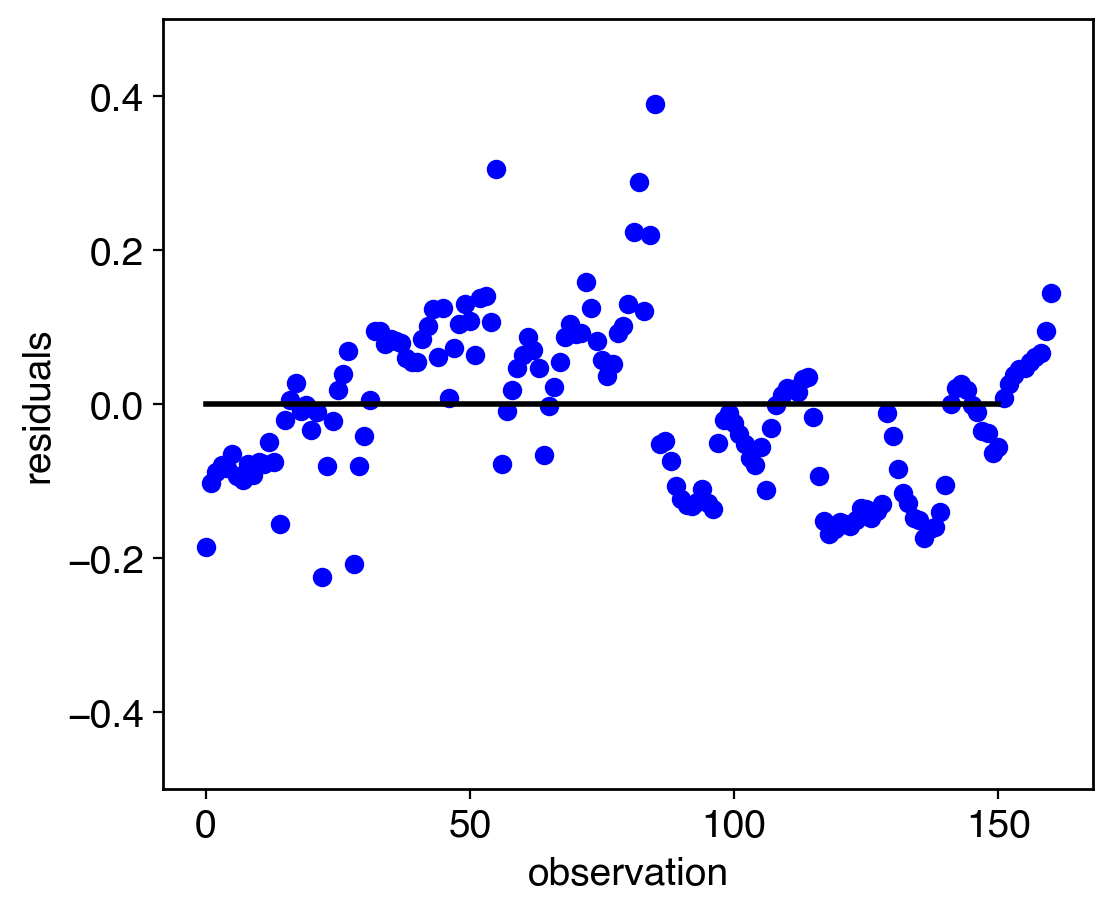

CPU times: user 299 ms, sys: 59.4 ms, total: 358 ms
Wall time: 207 ms


In [12]:
%%time
resid = Cdi - Cdi_pred
plt.plot(resid, 'bo')
plt.plot([0,150],[0,0], 'k-')
plt.ylim([-0.5,0.5])
plt.xlabel("observation")
plt.ylabel("residuals")
plt.show()